In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

# Model 1 (trend)
# from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
import warnings

c:\Users\HP\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
warnings.filterwarnings("ignore")

In [3]:
df_holidays = pd.read_csv('data/holidays_events.csv', header = 0)
df_oil = pd.read_csv('data/oil.csv', header = 0)
df_stores = pd.read_csv('data/stores.csv', header = 0)
df_trans = pd.read_csv('data/transactions.csv', header = 0)

df_train = pd.read_csv('data/train.csv', header = 0)
df_test = pd.read_csv('data/test.csv', header = 0)

In [4]:
#Converting all the date columns to pandas datetime format:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format = "%Y-%m-%d")

# Exploring all the dataframes

In [5]:
# holidays
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [6]:
# oils
df_oil.head(3)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


In [7]:
df_stores.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [8]:
#transaction data
df_trans.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


In [9]:
# train dataframe
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
df_test.head(5)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


# Visualizing data & EDA

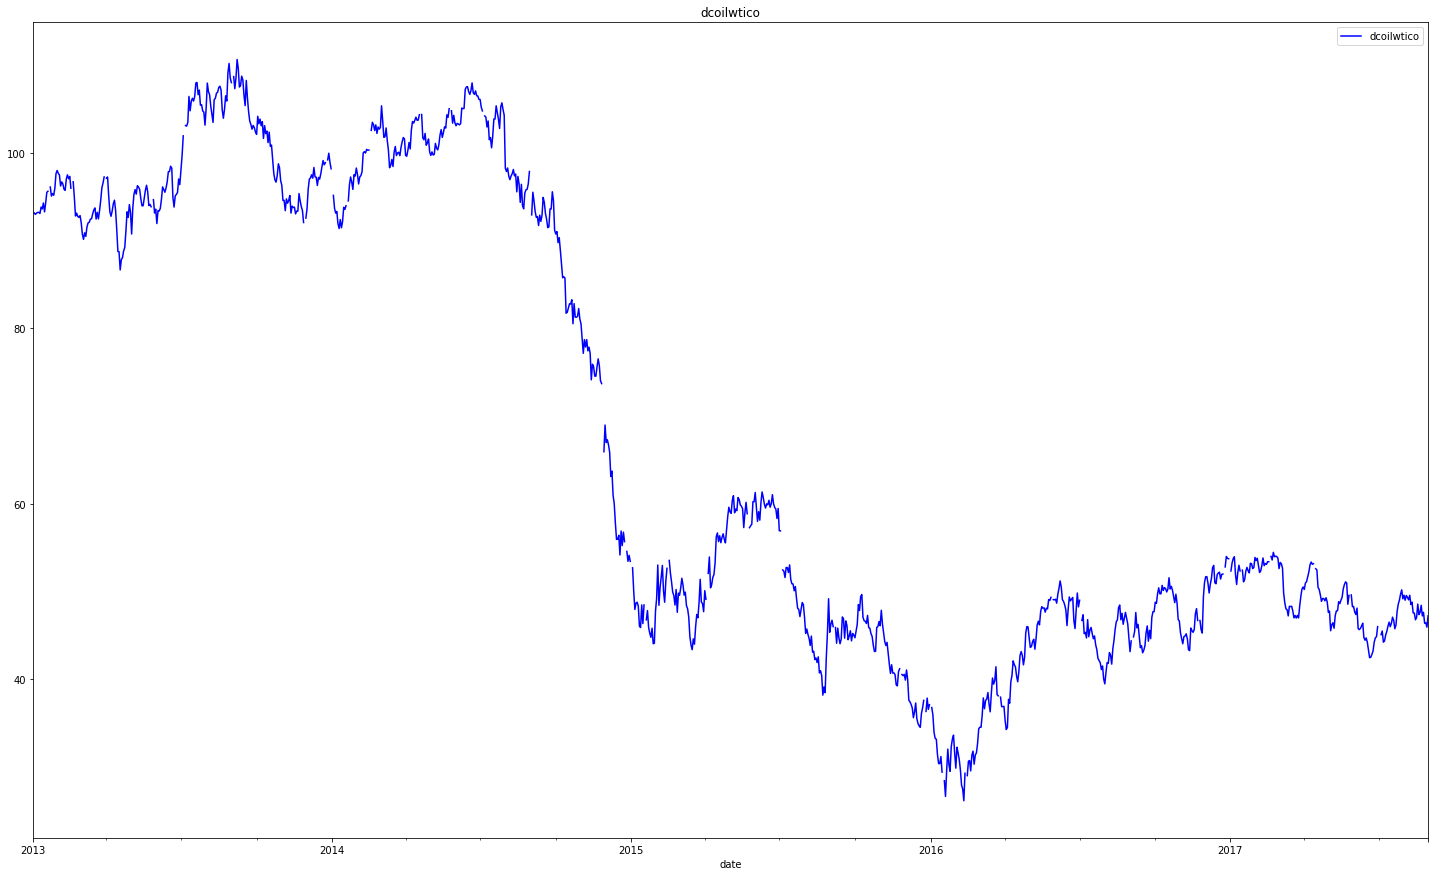

In [11]:
#Visualizing oil data
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
df_oil.plot.line(x="date", y="dcoilwtico", color='b', title ="dcoilwtico", ax = axes, rot=0)
plt.show()

In [12]:
# As we have so much rows in out dataset, it will be easier to group data, as example, by week or month. 
# The aggregation will be made by mean.

def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [13]:
# group data by weak
df_grouped_trans_w = grouped(df_trans, 'date', 'W', 'transactions')
df_grouped_trans_w

,date,mean
0,2013-01-06,1883.203463
1,2013-01-13,1641.090062
2,2013-01-20,1639.024845
3,2013-01-27,1609.816770
4,2013-02-03,1685.263975
...,...,...
237,2017-07-23,1623.208995
238,2017-07-30,1619.653439
239,2017-08-06,1713.743386
240,2017-08-13,1599.156085


In [14]:
# for better forecasting we'll add 'time' column to our dataframe.
def add_time(df, key, freq, col):
    """ ADD COLUMN 'TIME' TO DF """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [15]:
df_grouped_train_w = add_time(df_train, 'date', 'W', 'sales')
df_grouped_train_m = add_time(df_train, 'date', 'M', 'sales')

df_grouped_train_w.head() # check results

,date,time,mean
0,2013-01-06,0,206.843478
1,2013-01-13,1,190.285220
2,2013-01-20,2,189.835452
3,2013-01-27,3,182.152050
4,2013-02-03,4,198.564267


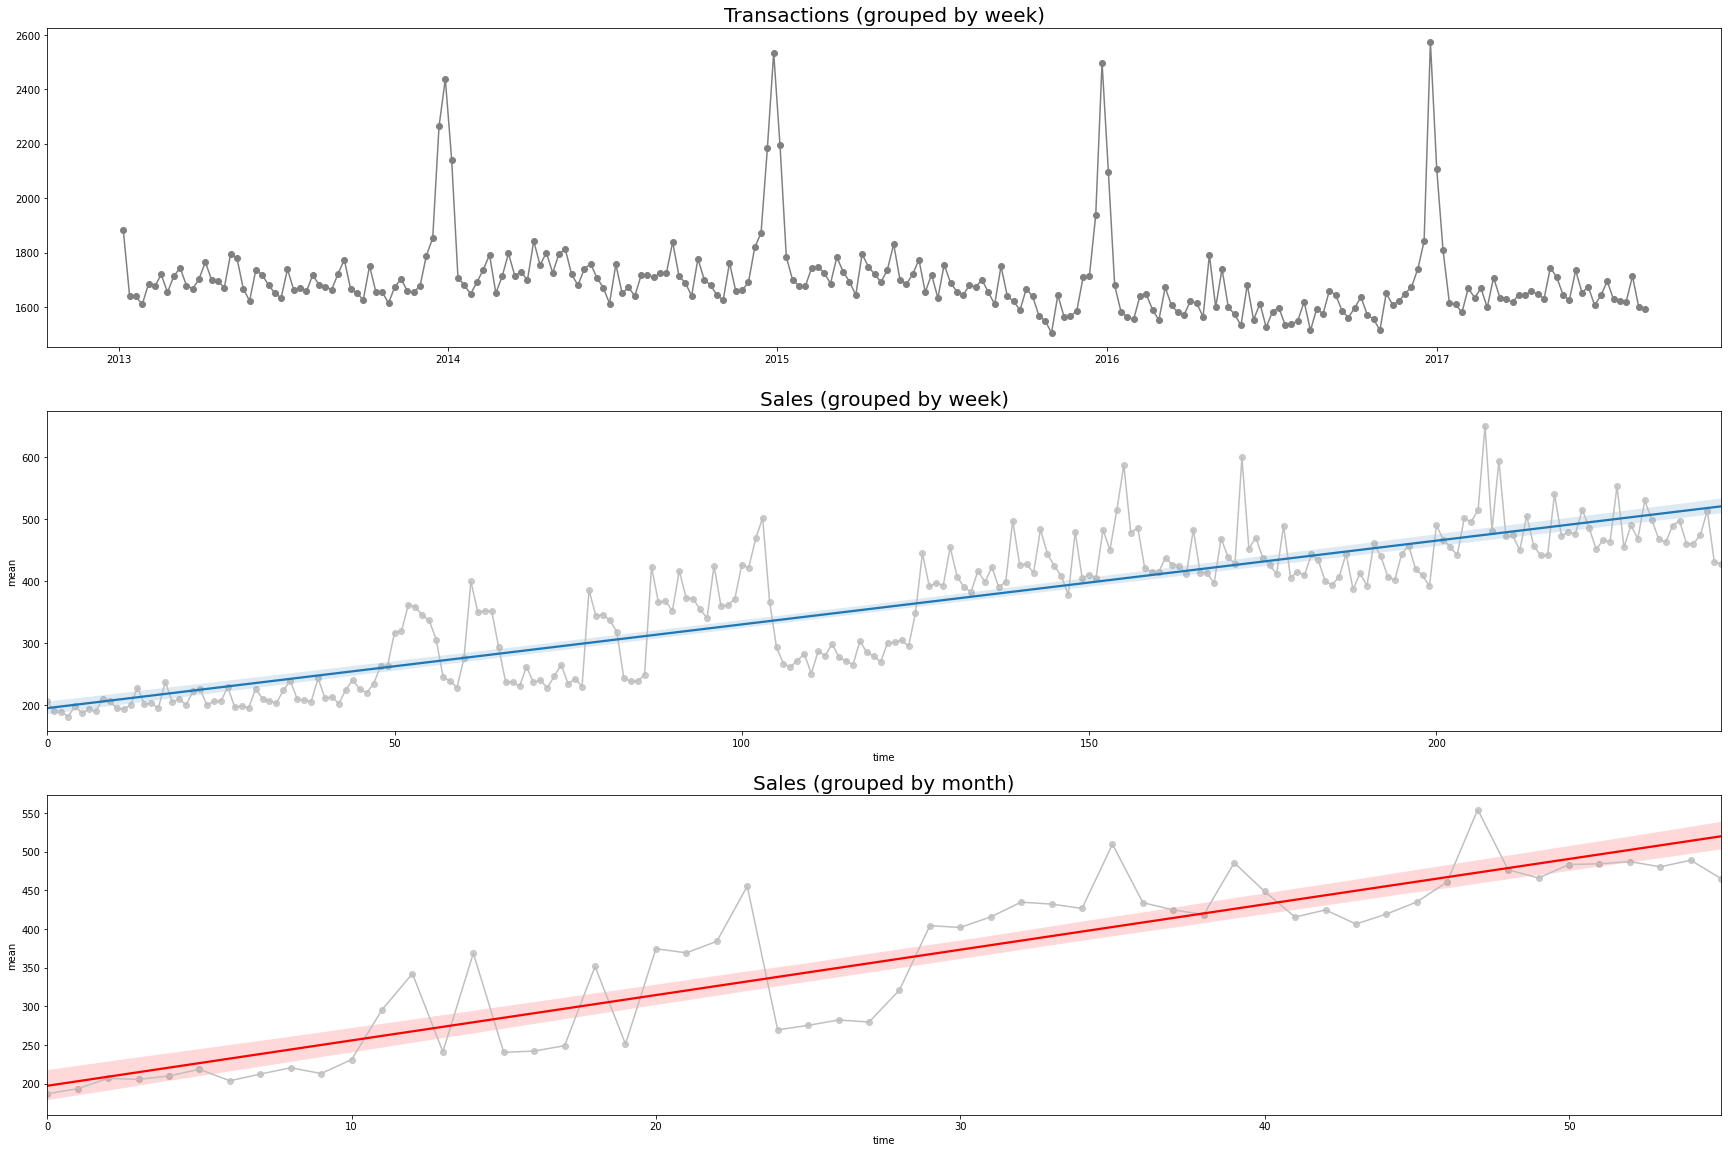

In [16]:
# using Linear regression to plot data and its trends
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,20))

# TRANSACTIONS (WEEKLY)
axes[0].plot('date', 'mean', data=df_grouped_trans_w, color='grey', marker='o')
axes[0].set_title("Transactions (grouped by week)", fontsize=20)

# SALES (WEEKLY)
axes[1].plot('time', 'mean', data=df_grouped_train_w, color='0.75')
axes[1].set_title("Sales (grouped by week)", fontsize=20)
# linear regression
axes[1] = sns.regplot(x='time', 
                      y='mean', 
                      data=df_grouped_train_w, 
                      scatter_kws=dict(color='0.75'), 
                      ax = axes[1])

# SALES (MONTHLY)
axes[2].plot('time', 'mean', data=df_grouped_train_m, color='0.75')
axes[2].set_title("Sales (grouped by month)", fontsize=20)
# linear regression
axes[2] = sns.regplot(x='time', 
                      y='mean', 
                      data=df_grouped_train_m, 
                      scatter_kws=dict(color='0.75'), 
                      line_kws={"color": "red"},
                      ax = axes[2])

plt.show()

In [17]:
# In time series Lag feature is widely used to shift the observations of the target series 
# so that they appear to have occured later in time.
def add_lag(df, key, freq, col, lag):
    """ ADD LAG """
    df_grouped = grouped(df, key, freq, col)
    name = 'Lag_' + str(lag)
    df_grouped['Lag'] = df_grouped['mean'].shift(lag)
    return df_grouped

In [18]:
df_grouped_train_w_lag1 = add_lag(df_train, 'date', 'W', 'sales', 1)
df_grouped_train_m_lag1 = add_lag(df_train, 'date', 'W', 'sales', 1)

df_grouped_train_w_lag1.head() # check data

,date,mean,Lag
0,2013-01-06,206.843478,NaN
1,2013-01-13,190.285220,206.843478
2,2013-01-20,189.835452,190.285220
3,2013-01-27,182.152050,189.835452
4,2013-02-03,198.564267,182.152050


In [24]:
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales'   , 'onpromotion']]
)

mag_sales = family_sales.loc(axis=1)[:, 'MAGAZINES']

In [25]:
store_sales.head()

id  sales  onpromotion
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-01     0    0.0            0
                     2013-01-02  1782    2.0            0
                     2013-01-03  3564    3.0            0
                     2013-01-04  5346    3.0            0
                     2013-01-05  7128    5.0            0

In [26]:
store_sales.index

MultiIndex([( 1, 'AUTOMOTIVE', '2013-01-01'),
            ( 1, 'AUTOMOTIVE', '2013-01-02'),
            ( 1, 'AUTOMOTIVE', '2013-01-03'),
            ( 1, 'AUTOMOTIVE', '2013-01-04'),
            ( 1, 'AUTOMOTIVE', '2013-01-05'),
            ( 1, 'AUTOMOTIVE', '2013-01-06'),
            ( 1, 'AUTOMOTIVE', '2013-01-07'),
            ( 1, 'AUTOMOTIVE', '2013-01-08'),
            ( 1, 'AUTOMOTIVE', '2013-01-09'),
            ( 1, 'AUTOMOTIVE', '2013-01-10'),
            ...
            (54,    'SEAFOOD', '2017-08-06'),
            (54,    'SEAFOOD', '2017-08-07'),
            (54,    'SEAFOOD', '2017-08-08'),
            (54,    'SEAFOOD', '2017-08-09'),
            (54,    'SEAFOOD', '2017-08-10'),
            (54,    'SEAFOOD', '2017-08-11'),
            (54,    'SEAFOOD', '2017-08-12'),
            (54,    'SEAFOOD', '2017-08-13'),
            (54,    'SEAFOOD', '2017-08-14'),
            (54,    'SEAFOOD', '2017-08-15')],
           names=['store_nbr', 'family', 'date'], length=300088

In [27]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222222  0.000000   
2017-01-02  11.481481  0.259259  11.648148  6208.055556  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814815  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833333  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796296  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518519    3.629167   
2017-01-02   844.836296   14.203704  2233.648148  1545.000000  539.114833   
2017-01-03   665.124111   10.629630  1711.907407  1204.203704  404.300074   
2017-01-04   594.160611   11.185185  1508.037037  1107.796296  309.397685   
2017-01-05   495.511611   12.444444  1241.833333   829.277778  260.776500   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [28]:
mag_sales.head()

,sales,onpromotion
family,MAGAZINES,MAGAZINES
date,,
2017-01-01,0.074074,0.0
2017-01-02,7.777778,0.0
2017-01-03,3.500000,0.0
2017-01-04,3.500000,0.0
2017-01-05,3.203704,0.0
